# Challenge 03: Data Modelling: From Retrieval to Upload (1/2)

In this step, we will structure the data retrieved from Azure Document Intelligence (ADI) into the right format to be read by our systems in subsequent steps. 

The data will be outputted from the ADI as a JSON file, and it is our role to process and organize it. Some of the data will be structured into tables, while other data will be formatted as text. This step ensures that the extracted information is organized in a meaningful way for further analysis and usage.

As stated before, we need to make sure that our Function will know how to process:
- **Loan Forms:** Extract relevant details such as borrower information, loan amounts, and terms.
- **Loan Contract:** Identify and parse key contract elements like clauses, signatures, and dates.
- **Pay Stubs:** Retrieve data such as employee details, earnings, deductions, and net pay.

Not all customers will have provided all types of content, and during this Challenge we will be only be processing one file. We will combine in the next challenge the capabilities of a trigger, which will, at a time, also process one single document.

Due to the nature of this challenge, we will separate this challenge in the 3 different types of documents.

In [11]:
from pydantic import BaseModel
from openai import AzureOpenAI
import os
import json
import pandas as pd
from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv
import re
from azure.cosmos import CosmosClient, exceptions, PartitionKey
from dotenv import load_dotenv
import os

## Loan Agreement


Now we get to the last part of our logical set of documents on a loan application process: the final loan agreement contract has been created and signed. A loan agreement contract is a legally binding document between a lender and a borrower that outlines the terms and conditions of a loan. This contract specifies the loan amount, interest rate, repayment schedule, and any other obligations or rights of both parties. It is crucial as it provides clarity and protection for both the lender and the borrower, ensuring that both parties understand their responsibilities and the consequences of default. Additionally, it serves as a legal record that can be referenced in case of disputes, helping to prevent misunderstandings and enforce the agreed-upon terms.

The format of a loan agreement is, on its core, a text document that will not have a fixed structure. We should expect just as an input text document and therefore retrieve it as such. 

As we did in the previous steps, let's call the function that will retrieve the information inside the loanagreements folder, retrieving, once again, one single Loan Agreement.


In [12]:
# Load environment variables from .env file
load_dotenv()

def read_json_files_from_blob(folder_path):
    # Retrieve the connection string from the environment variables
    connection_string = os.getenv('STORAGE_CONNECTION_STRING')

    # Ensure the connection string is not None
    if connection_string is None:
        raise ValueError("The connection string environment variable is not set.")

    # Create a BlobServiceClient
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)

    # Get the container client
    container_client = blob_service_client.get_container_client("data")

    # List all blobs in the specified folder
    blob_list = container_client.list_blobs(name_starts_with=folder_path)

    # Filter out JSON files and read their contents
    for blob in blob_list:
        if blob.name.endswith('.json'):
            blob_client = container_client.get_blob_client(blob.name)
            blob_data = blob_client.download_blob().readall()
            data = json.loads(blob_data)
            return data 

#### Loan Agreements

In [13]:
loanagreement = read_json_files_from_blob("loanagreements")

In [14]:
def clean_json_data(json_data):
    # Extract relevant text content from the JSON
    content = []

    # Extract text from paragraphs
    paragraphs = json_data.get("paragraphs", [])
    for paragraph in paragraphs:
        content.append(paragraph.get("text", "").strip())

    # Extract text from pages and lines
    pages = json_data.get("pages", [])
    for page in pages:
        for line in page.get("lines", []):
            content.append(line.get("text", "").strip())

    # Join all text content into a single string with spaces between components
    plain_text_content = " ".join(content)

    # Extract Customer ID using regex
    pattern = r"Customer ID:\s*(\d+)"
    match = re.search(pattern, plain_text_content)
    customer_id = match.group(1) if match else None
    return plain_text_content, customer_id

# Clean the JSON data and extract Customer ID
loanagreement_structured, customer_id = clean_json_data(loanagreement)

In [15]:
# Load environment variables from .env file
load_dotenv()

# Cosmos DB connection details from environment variables
endpoint = os.getenv("COSMOS_ENDPOINT")
key = os.getenv("COSMOS_KEY")

def upload_text_to_cosmos_db(text_content, container_name):
    # Check if the text is empty
    if not text_content:
        print("The text content is empty. No data to upload.")
        return
    
    # Initialize the Cosmos client
    client = CosmosClient(endpoint, key)
    
    try:
        # Create or get the database
        database = client.create_database_if_not_exists(id="ContosoDB")
        
        # Create or get the container
        container = database.create_container_if_not_exists(
            id=container_name,
            partition_key=PartitionKey(path=f"/id"),
            offer_throughput=400
        )
    except exceptions.CosmosHttpResponseError as e:
        print(f"An error occurred while creating the database or container: {e.message}")
        return
    
    # Create a document with the text content and partition key
    document = {
        'id': str(customer_id),  # Generate a unique ID for the document
        'content': text_content,  # Store the plain text as 'content'
    }
    
    # Upload the document to the container
    try:
        container.create_item(body=document)
        loanagreement_json = document
        print(f"Text content uploaded successfully with ID '{document['id']}' in Cosmos DB.")
    except exceptions.CosmosHttpResponseError as e:
        print(f"An error occurred while uploading the document: {e.message}")
    return document

### Upload Loan Agreements

In [16]:
upload_text_to_cosmos_db(loanagreement_structured, "LoanAgreements")

An error occurred while uploading the document: (Conflict) Entity with the specified id already exists in the system., 
RequestStartTime: 2024-11-22T10:16:26.0737432Z, RequestEndTime: 2024-11-22T10:16:26.0840897Z,  Number of regions attempted:1
{"systemHistory":[{"dateUtc":"2024-11-22T10:15:28.8471854Z","cpu":0.789,"memory":422394576.000,"threadInfo":{"isThreadStarving":"False","threadWaitIntervalInMs":0.0417,"availableThreads":32764,"minThreads":64,"maxThreads":32767},"numberOfOpenTcpConnection":142},{"dateUtc":"2024-11-22T10:15:38.8572922Z","cpu":0.347,"memory":422393144.000,"threadInfo":{"isThreadStarving":"False","threadWaitIntervalInMs":0.0296,"availableThreads":32764,"minThreads":64,"maxThreads":32767},"numberOfOpenTcpConnection":142},{"dateUtc":"2024-11-22T10:15:48.8673524Z","cpu":0.149,"memory":422410056.000,"threadInfo":{"isThreadStarving":"False","threadWaitIntervalInMs":0.0357,"availableThreads":32765,"minThreads":64,"maxThreads":32767},"numberOfOpenTcpConnection":142},{"dat

{'id': '100002',
 'content': 'LOAN AGREEMENT This Loan Agreement ("Agreement") is made and entered into on August 1, 2024, by and between: · Lender: Horizon Bank Address: 123 Finance Avenue, Madison, WI 53703 Contact Number: (555) 123-4567 Email: lending@horizonbank.com . Borrower: Jane Elizabeth Smith Customer ID: 100002 Address: 456 Oak Avenue, Unit 10, Madison, WI 53703 Contact Number: (555) 234-5678 Email: jane.smith90@example.com 1. Loan Amount and Purpose 1.1 Loan Amount: The Lender agrees to loan the Borrower the principal sum of $30,000.00 (thirty thousand dollars), referred to as the "Loan." 1.2 Purpose of Loan: The Loan shall be used exclusively for the purchase of a vehicle, specifically a 2022 Toyota Camry. 2. Interest Rate 2.1 Interest Rate: The Loan shall bear interest at an annual fixed rate of 5.5%. 2.2 Accrual: Interest shall begin to accrue on the Loan from the date the funds are disbursed to the Borrower. 3. Loan Term 3.1 Term: The term of this Loan shall be 5 years 

Now go back to your Azure Cosmos DB, check the container where the information of **Loan Agreements**. You should see a document that should be similar to this:

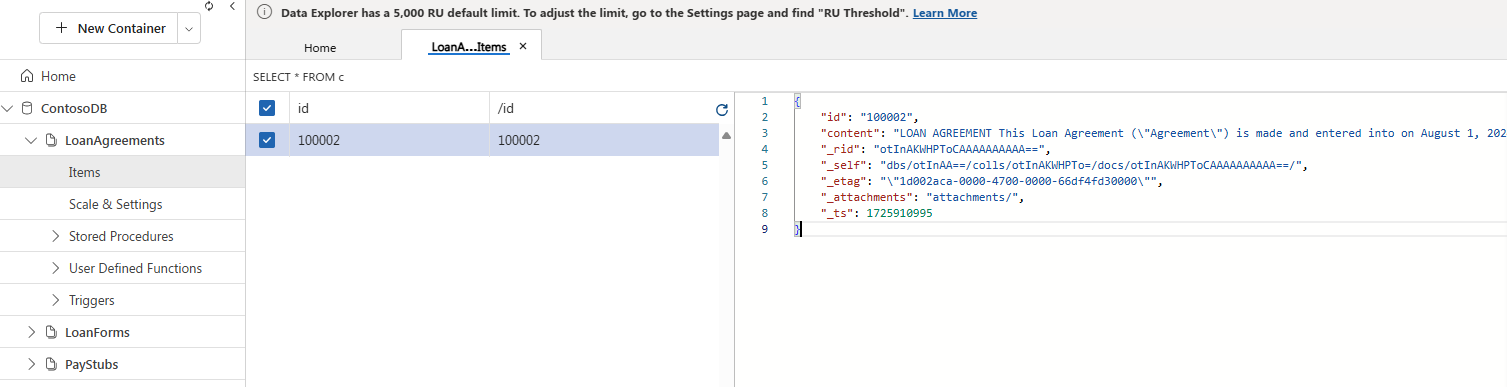

What we know, and due to this natural language nature, the content of our json is a long string, unlike the previous two examples that we have covered. But that's not what we want. The main goal of this process is to structure this information. So what can we do?

### Structuring Loan Agreements into JSON

In [17]:
from pydantic import BaseModel
from openai import AzureOpenAI

client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"),
  api_key=os.getenv("AZURE_OPENAI_KEY"),
  api_version= "2024-08-01-preview"
)


class CalendarEvent(BaseModel):
    lender_information: str
    borrower_informaiton: str
    customer_id: str
    loan_amount: str
    purpose_of_loan: str
    interest_rate: str
    term_years: str
    commencing_date: str
    ending_date: str
    monthly_payment: str
    late_payment_fee: str
    collateral: str

completion = client.beta.chat.completions.parse(
    model="gpt-4o", # replace with the model deployment name of your gpt-4o 2024-08-06 deployment
    messages=[
        {"role": "system", "content": "Extract the information about this loan agreement contract."},
        {"role": "user", "content": loanagreement_structured},
    ],
    response_format=CalendarEvent,
)

finaljsonstr = completion.model_dump_json(indent=2)

In [18]:
def formatted_data_cleaning(json_string):
    """
    Replaces the first 'id' in the JSON string with the 'customer_id' and returns the JSON with only the parsed information.

    Args:
        json_string (str): The original JSON string.

    Returns:
        dict: The modified JSON object with 'id' replaced by 'customer_id' and only the parsed information included.
    """
    # Load the JSON string into a Python dictionary
    data = json.loads(json_string)

    # Extract the parsed information
    parsed_info = data["choices"][0]["message"]["parsed"]

    # Replace the first id with the customer_id
    data["id"] = parsed_info["customer_id"]

    # Create a new dictionary with only the parsed information
    result = {
        "id": data["id"],
        **parsed_info
    }

    return result

# Example usage
result_json = formatted_data_cleaning(finaljsonstr)
print(result_json)

{'id': '100002', 'lender_information': 'Horizon Bank, Address: 123 Finance Avenue, Madison, WI 53703, Contact: (555) 123-4567, Email: lending@horizonbank.com', 'borrower_informaiton': 'Jane Elizabeth Smith, Customer ID: 100002, Address: 456 Oak Avenue, Unit 10, Madison, WI 53703, Contact Number: (555) 234-5678, Email: jane.smith90@example.com', 'customer_id': '100002', 'loan_amount': '$30,000.00', 'purpose_of_loan': 'Purchase of a 2022 Toyota Camry', 'interest_rate': '5.5% per annum', 'term_years': '5 years (60 months)', 'commencing_date': 'August 1, 2024', 'ending_date': 'August 1, 2029', 'monthly_payment': '$573.99', 'late_payment_fee': '$25.00', 'collateral': '2022 Toyota Camry'}


Now, one great thing about this Azure service is that it will not let us overwrite on the same `partition_id`. Therefore, what we will do is delete the record that we have previously uploaded, unformatted. 

1. Go back to your Cosmos DB.
2. On the upper part of the DB, just above the Loan Agreements tab, select your Item and click on `Delete`
3. Refresh the page
4. Ensure you have no items corresponding to the Loan Agreements

In [19]:
upload_text_to_cosmos_db(result_json, "LoanAgreements")

An error occurred while uploading the document: (Conflict) Entity with the specified id already exists in the system., 
RequestStartTime: 2024-11-22T10:16:42.4473136Z, RequestEndTime: 2024-11-22T10:16:42.4485474Z,  Number of regions attempted:1
{"systemHistory":[{"dateUtc":"2024-11-22T10:15:48.8673524Z","cpu":0.149,"memory":422410056.000,"threadInfo":{"isThreadStarving":"False","threadWaitIntervalInMs":0.0357,"availableThreads":32765,"minThreads":64,"maxThreads":32767},"numberOfOpenTcpConnection":142},{"dateUtc":"2024-11-22T10:15:58.8774899Z","cpu":0.957,"memory":422405944.000,"threadInfo":{"isThreadStarving":"False","threadWaitIntervalInMs":0.0435,"availableThreads":32764,"minThreads":64,"maxThreads":32767},"numberOfOpenTcpConnection":142},{"dateUtc":"2024-11-22T10:16:08.8875814Z","cpu":0.253,"memory":422407280.000,"threadInfo":{"isThreadStarving":"False","threadWaitIntervalInMs":0.0158,"availableThreads":32764,"minThreads":64,"maxThreads":32767},"numberOfOpenTcpConnection":142},{"dat

{'id': '100002',
 'content': {'id': '100002',
  'lender_information': 'Horizon Bank, Address: 123 Finance Avenue, Madison, WI 53703, Contact: (555) 123-4567, Email: lending@horizonbank.com',
  'borrower_informaiton': 'Jane Elizabeth Smith, Customer ID: 100002, Address: 456 Oak Avenue, Unit 10, Madison, WI 53703, Contact Number: (555) 234-5678, Email: jane.smith90@example.com',
  'customer_id': '100002',
  'loan_amount': '$30,000.00',
  'purpose_of_loan': 'Purchase of a 2022 Toyota Camry',
  'interest_rate': '5.5% per annum',
  'term_years': '5 years (60 months)',
  'commencing_date': 'August 1, 2024',
  'ending_date': 'August 1, 2029',
  'monthly_payment': '$573.99',
  'late_payment_fee': '$25.00',
  'collateral': '2022 Toyota Camry'}}